# Obuka dubokih neuronkih mreza

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Problemi nestajucih/eksplodirajucih gradijenta

Cesto gradijenti postaju sve manji i manji kako algoritam napreduje ka nizim slojevima, zbog toga se pri azuriranju gradijentnog spusta vrednosti parametara jako malo menjaju i algoritam ne konvergira. Takodje moze doci do eksplodirajucih gradijenta gde parametri postaju besmisleno vezi zbog velikih gradijenta.

Inicijalizacijom preko normalne distribucije i koriscenjem logisticke funkcije dokazano je da je varijasna na izlaznim slojevima mnogo veca nego na ulaznim (visi slojevi su osetljiviji od nizih). Varijansa na visim slojevima raste dok ne nastupi zasicenje aktivirajuce funkije na visim slojevima.<br>

In [6]:
def logit(z):
  return 1 / (1 + np.exp(-z))

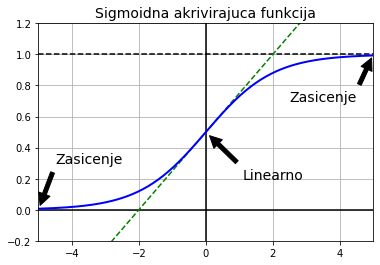

In [7]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Zasicenje', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Zasicenje', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linearno', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoidna akrivirajuca funkcija", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

Vrednosti na jako viskom i niskim vrednostima postaju 0 i 1 a izvod funkcije postaje blizu 0. Kada se pusti propagacija gotovo da nema gradijenta koji propagirali.

### Glorotova i Heova inicijalizacija

Glorot i Bengio su dosli do zakljucka da nam je potreban signal koji pravilno tece u oba smera bez da taj signal nestaje ili eksplodira. Da bi se ovako nesto postiglo potrebno je da varijansa izlaza svakog sloja treba da bude jednaka varijansi njegovih ulaza (primer vise pojacala koja se povezuju, signal od proslih treba da bude takav da ga novo pojacalo primi bez da taj signal bude prejak ili preslab).

<b>Glorotova jednacina</b><br>
Normalna distribucija sa srednjom vrednoscu 0 i varijansom $\sigma^2=\frac{1}{fan_{avg}}$<br><br>
gde je $fan_{avg}$ srednja vrednost broja ulaza $fan_{in}$ i broja izlaza $fan_{out}$

LeCunova strategija zamenjuje $fan_{avg}$ sa $fan_{in}$

| Inicijalizacija | Aktivirajuce funkcije | $\sigma^2$ (Normalna) |
| --- | --- | --- |
| Glorotova | None, tanh, logisticka, softmax | 1 / $fan_{avg}$ |
| Heova | ReLU i varinajte | 2 / $fan_{in}$ |
| LeCunova | SELU | 1 / $fan_{in}$ |


Keras standardno koristi Glorotovu inicijalizaciju.

In [9]:
# Heova inicijalizacija
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

### Nezasicene aktivirajuce funkcije

Delimican uzrok problema s nestabilnim gradijentima je los izbor aktivirajuce funkije. Logisticka je jako losa zbog zasicenja dok je ReLU bolja jer nema zasicenja na pozitivnim vrednostima i lako se izracunava.

Ali ni ReLU funkcija nije savrsena. Pati od problema <i>umiruci ReLU</i> tj. neki neuroni proizvode samo nule na izlazima. To se dogadja kada je ponderisan zbir svih ulaza za sve trening skupove negativan, a gradijentni spust ne deluje na njega jer je gradijent funckije ReLU jednak nuli kada je ulaz funkcije negativan

Za resenje ovog problema potrebna nam je varijanta funkcije ReLU kao sto je <i>cureca ReLU</i> koje je difinisana kao $LeakyReLU_\alpha(z) = max(\alpha z,z)$ gde je $\alpha$ nagib funkcije za z < 0.

In [10]:
def leaky_relu(z, alpha=0.01):
  return np.maximum(alpha*z, z)

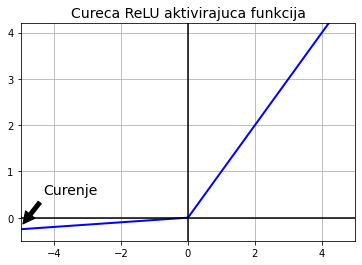

In [11]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Curenje', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Cureca ReLU aktivirajuca funkcija", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])

In [37]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7184
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7306 - val_accuracy: 0.7632
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7882
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6332 - accuracy: 0.7908 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5918 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5619 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accuracy:

Nakon LeakyReLU funkcije predlozena je nova aktivirajuca funkcija <i>eksponencijalna linearna jedinica ELU</i> koja je nadmasila performanse LeakyReLU funkcije. 

In [12]:
def elu(z, alpha=1):
  return np.where(z < 0, alpha * (np.exp(z) - 1), z)

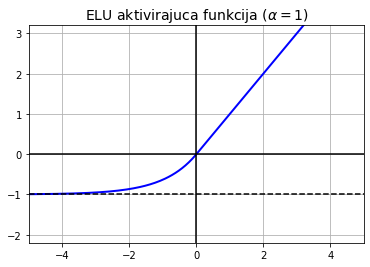

In [13]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU aktivirajuca funkcija ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

Funkcija ELU ima mnogo prednosti nad ReLU aktivirajucom funkcijaom:
1. Njena vrednost je negativna kada je z < 0 sto resava problem nestajucih gradijenta. 
2. Ima gradijent razlicit od nule za z < 0 cime se izbegava problem mrtvih neurona.
3. Ako je $\alpha$ jednako 1 funkcija je svuda glatka i u blizini z = 0 sto doprinosi ubrzavanju gradijetnog spusta jer nema mnogo skakutanja levo desno.

Ali funkcija ELU ima i manu: sporije se izracunava od funkcije ReLU. U vreme testiranja ELU mreza ce biti sporija od ReLU mreze.

Nakon toga otkrivena je aktivirajuca funkcija skaliraja ELU (SELU). Ako se NN sastoji samo od gustih slove sa SELU aktivirajucom funkcijom i LeCunovom inicijalizacijom, NN ce se samonormalizovati sto resava problema gradijenta. Rezultat ovoga je da SELU pruza bolje performanse od ostalih aktivirajucih funkcija. Problem sa SELU je da je samonormalizacija lako polomljena, nije moguce koristiti $l_1$ i $l_2$ regularizaciju, dropout ili bilo koju arhitekturu koja nije sekvencijalana.

In [14]:
from scipy.special import erfc

# alpha i scale za samonormalizovanje sa mena 0 i std dev 1
# (jednacina 14 u radu):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [15]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
  return scale * elu(z, alpha)

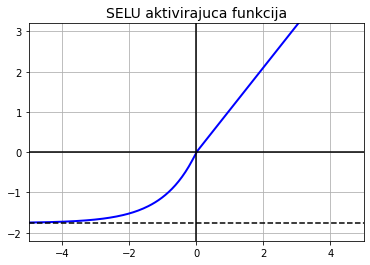

In [18]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU aktivirajuca funkcija", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [19]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Treniranje NN na Fashion MNIST podacima

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation='selu', 
                             kernel_initializer=keras.initializers.lecun_normal))

for layer in range(99):
  model.add(keras.layers.Dense(100, activation='selu', 
                               kernel_initializer=keras.initializers.lecun_normal))
  
model.add(keras.layers.Dense(10, activation='softmax'))

2022-02-23 21:32:20.904964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 21:32:21.104742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 21:32:21.104993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 21:32:21.105657: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [23]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics = ['accuracy'])

In [10]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [27]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 22s 13ms/step - loss: 1.2800 - accuracy: 0.5099 - val_loss: 1.1190 - val_accuracy: 0.5512
Epoch 2/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.8012 - accuracy: 0.7084 - val_loss: 0.6667 - val_accuracy: 0.7574
Epoch 3/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.6434 - accuracy: 0.7658 - val_loss: 0.6448 - val_accuracy: 0.7776
Epoch 4/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.5742 - accuracy: 0.7943 - val_loss: 0.5637 - val_accuracy: 0.7988
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.5451 - accuracy: 0.8069 - val_loss: 0.5119 - val_accuracy: 0.8210


Koriscenje ReLU funkcije umesto SELU

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation='relu', 
                             kernel_initializer=keras.initializers.he_normal))

for layer in range(99):
  model.add(keras.layers.Dense(100, activation='relu', 
                               kernel_initializer=keras.initializers.he_normal))
  
model.add(keras.layers.Dense(10, activation='softmax'))

In [31]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics = ['accuracy'])

In [32]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 24s 12ms/step - loss: 1.9541 - accuracy: 0.2341 - val_loss: 1.5532 - val_accuracy: 0.3258
Epoch 2/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.3378 - accuracy: 0.4192 - val_loss: 1.0254 - val_accuracy: 0.5392
Epoch 3/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.0356 - accuracy: 0.5684 - val_loss: 0.8602 - val_accuracy: 0.6294
Epoch 4/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.1306 - accuracy: 0.5278 - val_loss: 0.9272 - val_accuracy: 0.6206
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.9014 - accuracy: 0.6113 - val_loss: 0.9590 - val_accuracy: 0.6288


### Normalizacija paketa

Tehnika normalizacije paketa sastoji se u dodavanju odredjene operacije modelu neposredno pre ili posle aktivirajuce funkcije svakog skrivenog sloja. Ta operacija centrira na nulu i normalizuje svaku vrednost na ulazima a zatim skalira i pomera rezultat pomocu dva nova vektora parametara po sloju: jedan za skaliranje, a drugi za pomeranje.

Problem sa ovim pristupom je sta se dasava kada se model koristi. Tada nemamo paket koji bi normalizovali vec samo jedan primer. U kerasu je implementiran pristup pokretnih proseka srednjih vrednosti i standardnih odstupanja na ulazima.

Pokazano je da normalizacija paketa znacajno poboljsava duboke neuronske mreze dovodeci do velikog broja poboljsanja obrade. Problem nestajucih gradijenta je ublazen. Moguce je koristiti vece brzine ucenja sto znacajno ubrzava postupak ucenja. Pored svega ovog normalizacija paketa sluzi i kao regularizator i smanjuje potrebu za drugim tehnikama regularizacije.

In [4]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28,28]),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(10, activation='softmax')
])

2022-02-24 20:30:04.506110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 20:30:04.686733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 20:30:04.686969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 20:30:04.687516: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [6]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [8]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.8668 - accuracy: 0.7094 - val_loss: 0.5816 - val_accuracy: 0.8052
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5984 - accuracy: 0.7947 - val_loss: 0.5063 - val_accuracy: 0.8304
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5408 - accuracy: 0.8133 - val_loss: 0.4710 - val_accuracy: 0.8408
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5080 - accuracy: 0.8229 - val_loss: 0.4482 - val_accuracy: 0.8482
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4876 - accuracy: 0.8304 - val_loss: 0.4329 - val_accuracy: 0.8554
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4702 - accuracy: 0.8373 - val_loss: 0.4216 - val_accuracy: 0.8606
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4576 - accuracy: 0.8411 - val_loss: 0.4125 - val_accuracy:

### Odsecanje gradijenta

Druga popularna tehnika za ublazavanje problema eksplodirajucih gradijenta je orsecanje gradijenta tokom povratne propagacije rako da nikad ne premase odredjeni prag. Koristi se kod rekurentnih mreza jer je primena BN kod njih teska.

In [9]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [10]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Visekratna upotreba preobucenih slojeva

Ova tehnika se sastoji na nalazenju vec naucene neuralne mreze koja resava zadatak slican trazenom i od nje uzeti skrivene slojeve i zamrznuti nize i tako iskoristiti delove te prosle neuralne mreze da bi se dobila nova koja resava slican zadatak.

### Prenosno ucenje u Kerasu

## Brzi optimizatori

| Klasa | Brzina konvergiranja | Kvalitet konvergiranja |
| --- | --- | --- |
| SGD | * | ***|
| SGD(momentum=...) | ** | ***|
| SGD(momentum=..., nesterov=True) | ** | ***|
| AdaGrad | *** | * |
| RMSProp | *** | ** ili ***|
| Adam | *** | ** ili ***|
| Nadam | *** | ** ili ***|

### Optimizacija momenta

Optimizacija momenta se zasniva na ideji kugle koja se spusta niz padinu i kako se spusta dobija sve veci zalet (momenat). 

Optimizacija momenta vodi racuna o prethodnim gradijentima u svakoj iteraciji oduzima lokalni gradijent od vektora momenta m i azurira tezine sabiranjem vektora momenta. Drugim recima gradijent se koristi za ubrzanje a ne za brzinu. Algoritam uvodi novi hiperparametar $\beta$ (zalet) koji predstavlja trenje. Obicna vrednost mu je 0.9.

$m \leftarrow \beta m - \eta \nabla_{\theta}J(\theta)$

$\theta \leftarrow \theta + m$

In [11]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### Nesterovljev ubrzan gradijent

Resavanje $\theta - \beta m$ dobijamo aproksimaciju pozicije loptice nakon koraka i uz pomoc toga mozemo da kalkulisemo gradijent odakle bi loptica bila ne gde trenutno jeste.

$m \leftarrow \beta m - \eta \nabla_{\theta}J(\theta - \beta m)$

$\theta \leftarrow \theta + m$

NAG je uglavnom brzi od obicne optimizacije momenta.

In [12]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

### AdaGrad

$s \leftarrow s + \nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta)$

$\theta \leftarrow \theta - \eta\nabla_{\theta}J(\theta) \oslash \sqrt{s + \varepsilon}$

s akumulira kvadrate gradijenta a u drugom koraku se gradijent skalira nadole za faktor $\sqrt{s + \varepsilon}$ gde je $\varepsilon$ mali broj cija je svrha da izbegne deljenje sa nulom.

Ovaj algoritam u praksi previse brzo skalira nadole gradijent tako da retko stize do minimuma i ovaj algoritam se ne koristi ali je bitan za razumevanje ostalih.

### RMSProp

RMSProp ispravlja greske AdaGrad algoritma tako sto akumulira samo gradijente iz nedavnih iteracija (nasuprot gradijentima od poectka obuke). To radi tako sto u prvom koraku primenjuje eksponencijalno opadanje.

$s \leftarrow \beta s + (1 - \beta)\nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta)$

$\theta \leftarrow \theta - \eta\nabla_{\theta}J(\theta) \oslash \sqrt{s + \varepsilon}$

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

rho odgovara hiperparametru stopa opadanja $\beta$ i cesto je vrednost 0.9 sasvim dobra

### Adam i Nadam optimizacija

Adam optimizacija kombinuje ideje optimizacije momenta i RMSPropa: isto kao optimizacija momenta, belezi eksponencijalno opadajuci prosek prethodnih gradijenta, a isto kao RMSProp belezi eksponencijalno opadajuci prosek kvadrata prethodnih gradijenta.

In [3]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

beta_1 -> skaliranje momenta<br>
beta_2 -> skliranje opadanja

#### Nadam optimizacija

Adam optimizacija + Nestorvljev trik. Daje bolje performanse od Adam algoritma ali je ponekad od njega bolji RMSProp.

In [4]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Raspored brzine ucenja

Tehnika rasporeda brzine ucenja predstavlja menjanje brzine ucenja od zavisnosti od strategije. Npr. brzina je u pocetku velika ali se smanji kako se algoritam priblizava minimumu.

### Raspored u zavisnosti od stepena

$\eta(t)=\eta_0 / (1 + t/s)^c$

Brzina ucenja opada na svakom koraku. Nakon <b>s</b> koraka brzina ucenja opada na $\eta_0/2$ zatim na $\eta_0/3$ itd. Brzina u pocetku opada brzo pa sve sporije i sporije.

In [5]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [8]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28,28]),
  keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
  keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
  keras.layers.Dense(10, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [11]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4886 - accuracy: 0.8274 - val_loss: 0.4132 - val_accuracy: 0.8572
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3825 - accuracy: 0.8652 - val_loss: 0.3782 - val_accuracy: 0.8748
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3490 - accuracy: 0.8752 - val_loss: 0.3617 - val_accuracy: 0.8730
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3264 - accuracy: 0.8833 - val_loss: 0.3544 - val_accuracy: 0.8740
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3110 - accuracy: 0.8883 - val_loss: 0.3447 - val_accuracy: 0.8806
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2982 - accuracy: 0.8939 - val_loss: 0.3409 - val_accuracy: 0.8812
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2878 - accuracy: 0.8968 - val_loss: 0.3423 - val_accuracy:

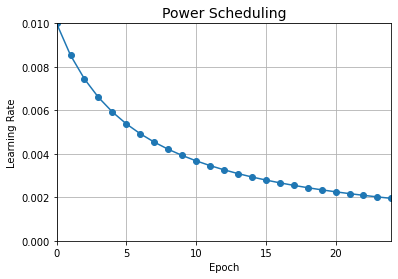

In [12]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Eksponencijalni raspored

$\eta(t)=\eta_0 0,1^{t/s}$

Brzina ucenja opada za vaktor 10 svakih s koraka.

In [13]:
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1**(epoch/s)
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [14]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [15]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 3ms/step - loss: 0.8789 - accuracy: 0.7507 - val_loss: 0.7017 - val_accuracy: 0.8088 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7053 - accuracy: 0.7829 - val_loss: 0.8264 - val_accuracy: 0.7308 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6085 - accuracy: 0.8104 - val_loss: 0.6591 - val_accuracy: 0.8198 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5420 - accuracy: 0.8307 - val_loss: 0.5827 - val_accuracy: 0.8402 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5124 - accuracy: 0.8433 - val_loss: 0.6305 - val_accuracy: 0.8188 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4609 - accuracy: 0.8540 - val_loss: 0.5033 - val_accuracy: 0.8376 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 6s

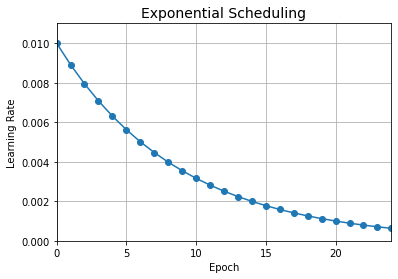

In [16]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Raspored u konstantnim blokovima

Brzina ucenja je konstantna tokom zadatog broja ciklusa (npr. $\eta_0 = 0.1$ tokom 5 ciklusa), zatim se smanjuje tokom drugog broja narednih ciklusa (npr. $\eta_1 = 0.001$ tokom 50 ciklusa). Ovo resenje zahteva puno rucnog petljanja dok se ne nadje odgovarajuca sekvenca brzina ucenja i koliko dugo treba da se koristi svaka od njih

In [17]:
def piecewise_constant(boundaries, values):
  boundaries = np.array([0] + boundaries)
  values = np.array(values)
  def piecewise_constant_fn(epoch):
    return values[np.argmax(boundaries > epoch) - 1]
  return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [18]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8295 - accuracy: 0.7583 - val_loss: 1.0209 - val_accuracy: 0.7172 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8903 - accuracy: 0.7526 - val_loss: 0.9107 - val_accuracy: 0.7494 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8806 - accuracy: 0.7367 - val_loss: 1.0126 - val_accuracy: 0.7056 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 1.2916 - accuracy: 0.6110 - val_loss: 1.4490 - val_accuracy: 0.5102 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0872 - accuracy: 0.6295 - val_loss: 1.1102 - val_accuracy: 0.6144 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8003 - accuracy: 0.6967 - val_loss: 0.7773 - val_accuracy: 0.7386 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 6s

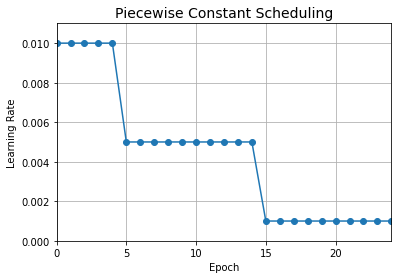

In [19]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Raspored u zavisnosti od performansi

Svakih N koraka meri se greska provere (isto kao kod ranog zaustavljanja obuke), a brzina ucenja se za faktor $\lambda$ kada te greska prestane da opada.

In [20]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5900 - accuracy: 0.8088 - val_loss: 0.5170 - val_accuracy: 0.8312 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5164 - accuracy: 0.8365 - val_loss: 0.4535 - val_accuracy: 0.8498 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5283 - accuracy: 0.8428 - val_loss: 0.4843 - val_accuracy: 0.8568 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5046 - accuracy: 0.8471 - val_loss: 0.7030 - val_accuracy: 0.8250 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5109 - accuracy: 0.8506 - val_loss: 0.5841 - val_accuracy: 0.8432 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5079 - accuracy: 0.8546 - val_loss: 0.6138 - val_accuracy: 0.8620 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 4s

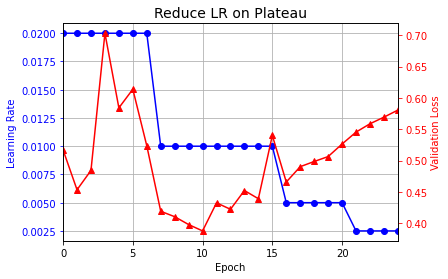

In [21]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1cycle rapored

Radi tako sto povecava pocetnu brzinu ucenja $\eta_0$ koja raste linearno do $\eta_1$ tokom prve polovine obuke. Zatim se brzina linearno smanjuje na $\eta_0$ tokom druge polovine obuke, da bi u poseldnjih nekoliko ciklusa ta brzina opala za vise redova velicine(i dalje linearno). Maksimalna brzina ucenja $\eta_1$ se bira na isti nacin kao kada smo trazili optimalnu brzinu ucenja, a pocetna brzina ucenja $\eta_0$ se menja tako da bude otpilike 10 puta niza.

In [23]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
  def __init__(self, factor):
    self.factor = factor
    self.rates = []
    self.losses = []
  def on_batch_end(self, batch, logs):
    self.rates.append(K.get_value(self.model.optimizer.learning_rate))
    self.losses.append(logs['loss'])
    K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
  init_weights = model.get_weights()
  iterations = math.ceil(len(X) / batch_size) * epochs
  factor = np.exp(np.log(max_rate / min_rate) / iterations)
  init_lr = K.get_value(model.optimizer.learning_rate)
  K.set_value(model.optimizer.learning_rate, min_rate)
  exp_lr = ExponentialLearningRate(factor)
  history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                      callbacks=[exp_lr])
  K.set_value(model.optimizer.learning_rate, init_lr)
  model.set_weights(init_weights)
  return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
  plt.plot(rates, losses)
  plt.gca().set_xscale('log')
  plt.hlines(min(losses), min(rates), max(rates))
  plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
  plt.xlabel("Learning rate")
  plt.ylabel("Loss")
  

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.3857


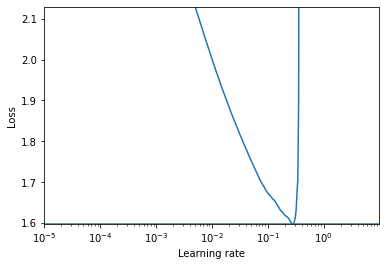

In [25]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [28]:
class OneCycleScheduler(keras.callbacks.Callback):
  def __init__(self, iterations, max_rate, start_rate=None,
               last_iterations=None, last_rate=None):
    self.iterations = iterations
    self.max_rate = max_rate
    self.start_rate = start_rate or max_rate / 10
    self.last_iterations = last_iterations or iterations // 10
    self.half_iteration = (iterations - self.last_iterations)
    self.last_rate = last_rate or self.start_rate / 1000
    self.iteration = 0
  def _interpolate(self, iter1, iter2, rate1, rate2):
    return ((rate2 - rate1) * (self.iteration - iter1)
            / (iter2 - iter1) + rate1)
  def on_batch_begin(self, batch, logs):
    if self.iteration < self.half_iteration:
      rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
    elif self.iteration < 2 * self.half_iteration:
      rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, 
                               self.max_rate, self.start_rate)
    else:
      rate = self._interpolate(2 * self.half_iteration, self.iterations,
                               self.start_rate, self.last_rate)
    self.iteration += 1
    K.set_value(self.model.optimizer.learning_rate, rate)

In [29]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 3ms/step - loss: 0.6655 - accuracy: 0.7712 - val_loss: 0.4989 - val_accuracy: 0.8276
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4699 - accuracy: 0.8363 - val_loss: 0.4396 - val_accuracy: 0.8502
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4249 - accuracy: 0.8508 - val_loss: 0.4221 - val_accuracy: 0.8546
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3972 - accuracy: 0.8605 - val_loss: 0.3993 - val_accuracy: 0.8632
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3777 - accuracy: 0.8678 - val_loss: 0.3863 - val_accuracy: 0.8628
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3605 - accuracy: 0.8728 - val_loss: 0.3805 - val_accuracy: 0.8694
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3475 - accuracy: 0.8767 - val_loss: 0.3709 - val_accuracy: 0.8678
Epoch 

## Izbegavanje prekomernog uklapanja pomocu regularizacije

## $l_1$ i $l_2$ regularizacija

In [2]:
layer = keras.layers.Dense(100, activation='elu',
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [3]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation='elu',
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(0.01))

### Izostavljanje

Izostavljanje predstavlja algoritam gde u svakom koraku obuke svaki neuron ima verovatnocu <i>p</i> da ce privremeno biti izostavljen, sto znaci da ce tokom tekuceg koraka obuke biti u potpunosti zanemaren.

Hiperparametar p (dropout rate) se obicno postavlja izmedju 10% i 50% blize 20%-30% u rekurentnim mrezama i blize 40%-50% u konvolucionalnim.

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

2022-02-27 10:48:14.491988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 10:48:15.420407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 10:48:15.420631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 10:48:15.465848: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

U praksi se izostavljaju samo neuroni iz najvisa tri sloja (ne i izlazni sloj).

Ako se koristi selu aktivirajuca funkcija treba koristiti alfa dropout koji cuva srednje vrednosti i standardna odstupanja na ulazima.

In [5]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### Monte Carlo izostavljanje

Izracunavanjem proseka vise predvidjanja sa izostavljanjem dobije se MOnte Carlo procena, koja je uglavnom pouzdanija od rezultata jednog predvidjanja i bez izostavljanja.

# Vezbe

## Cifar 10 DNN

### a.

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.

In [7]:
model.add(keras.layers.Dense(10, activation='softmax'))

In [8]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170508288/170498071 [==============================] - 33s 0us/step


In [12]:
early_stopping_Cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('../keras/models/my_cifar10.h5', save_best_only=True)
run_index = 1
run_logdir = '../keras/logs/my_cifar10'
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_Cb, model_checkpoint_cb, tensorboard_cb]

In [14]:
%load_ext tensorboard
%tensorboard --logdir=../keras/logs/my_cifar10 --port=6006

In [16]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 15s 10ms/step - loss: 3.9897 - accuracy: 0.1616 - val_loss: 2.1485 - val_accuracy: 0.2274
Epoch 2/100
1407/1407 [==============================] - 15s 10ms/step - loss: 2.0470 - accuracy: 0.2477 - val_loss: 2.1069 - val_accuracy: 0.2270
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.9143 - accuracy: 0.2953 - val_loss: 1.9380 - val_accuracy: 0.2890
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.8401 - accuracy: 0.3236 - val_loss: 1.8780 - val_accuracy: 0.3232
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7843 - accuracy: 0.3492 - val_loss: 1.7715 - val_accuracy: 0.3544
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7408 - accuracy: 0.3684 - val_loss: 1.8059 - val_accuracy: 0.3454
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7031 - accuracy: 0.3836 - val_loss: 1

In [17]:
model = keras.models.load_model('../keras/models/my_cifar10.h5')
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.5123 - accuracy: 0.4714


[1.5123132467269897, 0.4713999927043915]

### c.

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
  model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)  
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('../keras/models/my_cifar10_bn.h5')
run_index = 1
run_logdir = '../keras/logs/my_cifar10/run_bn_' + str(run_index)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs = 100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model('../keras/models/my_cifar10_bn.h5')
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 86s 27ms/step - loss: 1.8462 - accuracy: 0.3372 - val_loss: 1.6551 - val_accuracy: 0.4042
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.6689 - accuracy: 0.4060 - val_loss: 1.5856 - val_accuracy: 0.4348
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.6007 - accuracy: 0.4338 - val_loss: 1.5320 - val_accuracy: 0.4532
Epoch 4/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.5532 - accuracy: 0.4477 - val_loss: 1.5019 - val_accuracy: 0.4634
Epoch 5/100
1407/1407 [==============================] - 37s 27ms/step - loss: 1.5092 - accuracy: 0.4643 - val_loss: 1.4607 - val_accuracy: 0.4776
Epoch 6/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1.4715 - accuracy: 0.4807 - val_loss: 1.4383 - val_accuracy: 0.4880
Epoch 7/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1.4391 - accuracy: 0.4885 - val_loss: 1

[1.3331319093704224, 0.548799991607666]